In [1]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy

import seaborn as sns
import numpy


import itertools

from functools import partial

In [2]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=False,transverse=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    boltzmann machine .
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    restricted (bool) 
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    
    if transverse==True:
        for i in range(num_qubits):
            
            pauli_string = ['I'] * num_qubits
            pauli_string[i] = 'X'
            
            pauli_strings.append(''.join(pauli_string))

    for i in range(num_qubits):
        
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    
    
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                
                pauli_string = ['I'] * num_qubits
                
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                   
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['XIIIIII',
 'IXIIIII',
 'IIXIIII',
 'IIIXIII',
 'IIIIXII',
 'IIIIIXI',
 'IIIIIIX',
 'ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [21]:
import seaborn as sns

def evaluate_qbm(qbm,testing_dataset,cluster,plot=False,quantile=0.95,method='min'):

    '''
    Evaluates the QBM pn the testing dataset.
    Parameters:
    qbm : QBM instance
    testing_dataset 
    cluster : The number of clusters in the dataset
    quantile
    method : When 'min' is used the energy of a given input vector is taken to be the minimum energy that total configuration achieves.
            In case of 'mean' the average value is used to assign it an energy.

    Returns:
    precision, recall, f1_score
    
    '''
    #training_data=numpy.expand_dims(training_data[:,0],axis=1)
    outliers = qbm.get_binary_outliers(
    dataset=testing_dataset, outlier_index=cluster)

    #outliers=numpy.expand_dims(outliers[:,0],axis=1)
    

    points = qbm.get_binary_cluster_points(
    dataset=testing_dataset, cluster_index=cluster-1)

    #points=numpy.expand_dims(points[:,0],axis=1)
    #print(points)
    predict_points_cluster = np.zeros(len(points), dtype=int)
    predict_points_outliers = np.zeros(len(outliers), dtype=int)
    qbm.calculate_outlier_threshold(quantile, method)
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Calculate outlier Energy")
    
    testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

    outlier_energy = []
    for index, outlier in enumerate(tqdm(outliers), 0):
        outlier = np.reshape(outlier, (qbm.dim_input))
        predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
            outlier,method)
        outlier_energy.append(this_outlier_energy)
    outlier_energy = np.array(outlier_energy)

    o = outlier_energy.reshape((outlier_energy.shape[0]))

    print("Calculate cluster energy")
    cluster_point_energy = []

    for index, point in enumerate(tqdm(points), 0):
        point = np.reshape(point, (qbm.dim_input))
        predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point,method)
        cluster_point_energy.append(this_cluster_point_energy)
    cluster_point_energy = np.array(cluster_point_energy)

    c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

    title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
    print('Outlier classification: Results...')
    predict_points = np.concatenate(
        (predict_points_cluster, predict_points_outliers))

    print("Predicted points test: ", predict_points)

    true_points = np.concatenate(
        (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

    accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
        true_points, predict_points), recall_score(true_points, predict_points)
    f1 = f1_score(true_points, predict_points)
    tn, fp, fn, tp = confusion_matrix(
        true_points, predict_points, labels=[0, 1]).ravel()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')
    lab=cluster-1
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Average clusterpoint energy: ", np.average(cluster_point_energy))
    print("Outlier energy: ", outlier_energy)
    
    if plot==True:
        plt.figure()
        plt.title('Test Dataset')
        sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
        sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')

        # Actual plotting
        # Display the plot
        fig = plt.figure(0)
        fig.suptitle('Point Energy', fontsize=14, fontweight='bold')

        ax = fig.add_subplot()
        ax.boxplot([o,c], showfliers=False, showmeans=True)
        ax.set_xticklabels(['outlier', 'cluster points'], fontsize=8)

        ax.set_ylabel('Energy')

        plt.axhline(qbm.outlier_threshold)

        plt.plot([], [], '-', linewidth=1, color='orange', label='median')
        plt.plot([], [], '^', linewidth=1, color='green', label='mean')
        plt.legend()

        

    
    
    #plt.title('Predicted Points')
    #sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=predict_points,palette='coolwarm')
    return precision,recall,f1

class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine
    hnodes : Number of hidden nodes
    epochs: Number of epochs to train
    restricted (bool): [default] True
    
    
    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True,transverse=False,t_bias=None) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.transverse=transverse
        self.enc = enc
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
       
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        self.t_bias=t_bias
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        #self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
       
    
        
        self.restricted=restricted

        self.H.θ[0:self.dim_input+self.n_hidden_nodes]=t_bias
        if transverse==True:
           
            if self.restricted:
                self.weights_visible_to_hidden=np.reshape(self.H.θ[2*self.dim_input+2*self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
                self.biases_hidden=self.H.θ[2*self.dim_input+self.n_hidden_nodes:2*self.dim_input+2*self.n_hidden_nodes]
                self.biases_visible=self.H.θ[self.dim_input+self.n_hidden_nodes:2*self.dim_input+self.n_hidden_nodes]
            else:
                
                self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ[self.n_hidden_nodes+self.dim_input:])
                self.biases_hidden=self.H.θ[2*self.dim_input+self.n_hidden_nodes:2*self.dim_input+2*self.n_hidden_nodes]
                self.biases_visible=self.H.θ[self.dim_input+self.n_hidden_nodes:2*self.dim_input+self.n_hidden_nodes]
            

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
       
            
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None
        
        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            if dev_name=='default.qubit':
                return self._measure()
            else:
                observation_wires=[[]]
                
                for term in self.H.h:
                    list=[]
                    for i,el in enumerate(term):
                        if el!='I':
                            list.append(i+self.n_qubits({'aux','enc'}))
                    observation_wires.append(list)
                
                probabilities=[qml.probs(wires=[0,1]+wires) for wires in observation_wires]

                return probabilities
                
            
        
        if dev_name=='default.qubit':
        
            measurements = quantum_circuit()
            
            success_probability = measurements[0]
           
            
            qbm_expvals = measurements[1:] / success_probability
            
            return qbm_expvals
        
        else:

            probabilities=quantum_circuit()
            success_probability=probabilities[0][0]
            print(success_probability)
            rest_probabilites=probabilities[1:]
            exp_val=[]
            for i,term in enumerate(rest_probabilites):
                if i<self.n_hidden_nodes+self.dim_input:
                
                    ps=np.reshape(term,(4,2))[0]
                
                    exp_val.append(ps[0]-ps[1])
                else:
                
                    ps=np.reshape(term,(4,4))[0]
        
                    exp_val.append(ps[0]-ps[1]-ps[2]+ps[3])      
            
        
        
       
            return np.array(exp_val)/success_probability
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector,k=10,method='min'):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
      

        D=new_biases**2+self.t_bias**2
        
        exp_vals=-(new_biases/D)*np.tanh(self.β*D)

        x_vals=-(self.t_bias/D)*np.tanh(self.β*D)
        z_energy= exp_vals*self.H.θ[self.dim_input+self.n_hidden_nodes:2*self.dim_input+2*self.n_hidden_nodes]
        x_energy= x_vals*self.t_bias[self.dim_input:self.dim_input+self.n_hidden_nodes]

        return z_energy+x_energy

            
     
    
    def free_energy(self,method='min',input_vector=None):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
        if self.n_hidden_nodes==0: 
            hidden_term=0
        else:
            hidden_term = self.get_energy(method=method,input_vector=input_vector)

        # calculate visible_term
        # visible bias
        visible_term = np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        pos_neg=1-2*input_vector
        if self.restricted==False:
             
             
             vv_interaction=np.matmul(self.weights_visible_to_visible,pos_neg)
             vv_interaction=np.matmul(pos_neg.T,vv_interaction)
             visible_term=visible_term+vv_interaction
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95,method='min'):
        
        self.quantile = quantile
        energy_func=partial(self.free_energy,method)
        
        energies = np.apply_along_axis(
            energy_func, axis=1, arr=self.encoded_data)
        
        self.outlier_threshold = np.quantile(energies, self.quantile)
        
        
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        
        If input vector is clamped at a certain value , it gives configuration of hidden units only.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ[self.n_hidden_nodes+self.dim_input:])
            self.biases_hidden=self.H.θ[2*self.dim_input+self.n_hidden_nodes:2*self.dim_input+2*self.n_hidden_nodes]
            self.biases_visible=self.H.θ[self.dim_input+self.n_hidden_nodes:2*self.dim_input+self.n_hidden_nodes]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        D=new_biases**2+self.t_bias[self.dim_input:self.dim_input+self.n_hidden_nodes]**2
        
        exp_vals=-(new_biases/D)*np.tanh(self.β*D)
        
        return exp_vals
            
       
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        '''
        Performs the update for one batch in the dataset.

        Parameters:

        batch 
        learning_rate
       
        Returns:
        list: List of avg errors in the visible configuration for each element of the batch.
        '''
        
        
        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                
                if self.transverse==True:
                    unclamped_config=unclamped_config[self.n_hidden_nodes+self.dim_input:]
                
                #print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            #print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
        
            
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ[self.dim_input+self.n_hidden_nodes:] = self.H.θ[self.dim_input+self.n_hidden_nodes] - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005,save=False):
        
        data = self.encoded_data
        
        weights=[]
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        qbm.batch_size=batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_epoch=[]
            for batch in tqdm(batches):
                    #print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_epoch.append(errors)
            
            losses.append(errors_epoch)
            weights.append(self.H.θ)
            if save==True:
                try:
                    np.savez(f'./epoch{epoch}_weights_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',self.H.θ)
                    np.savez(f'./epoch{epoch}_losses_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',errors_epoch)
                except:
                    print('error_saving')
        self.calculate_outlier_threshold(self.quantile)
        
        
        
        return losses, weights 
    
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input,method):
        energy = self.free_energy(method,input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
    def save_model(path,dataset_name):
         path=Path(path/dataset)
         path.mkdir(exist_ok=True)
         np.savez(f'_e{qbm.epochs}_h{qbm.n_hidden_nodes}_v{qbm.dim_input}_b{qbm.batch_size}',qbm.H.θ)
        
     
    

    


Stopping MATLAB engine ... Done.



C:\Users\ge84gac\AppData\Local\Temp\ipykernel_5300\1143533892.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


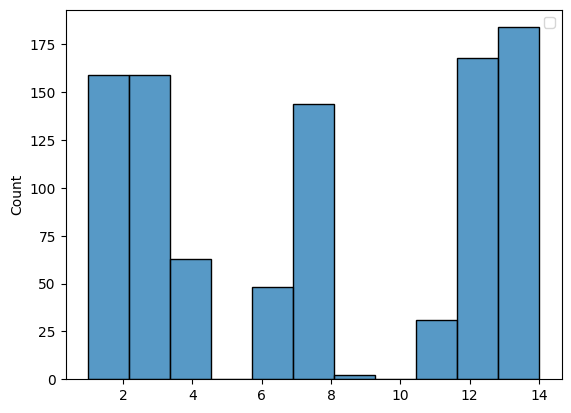

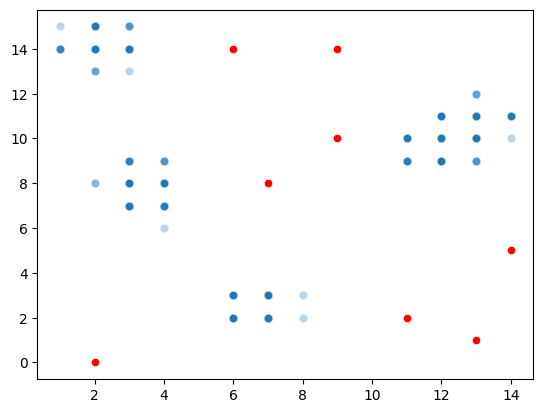

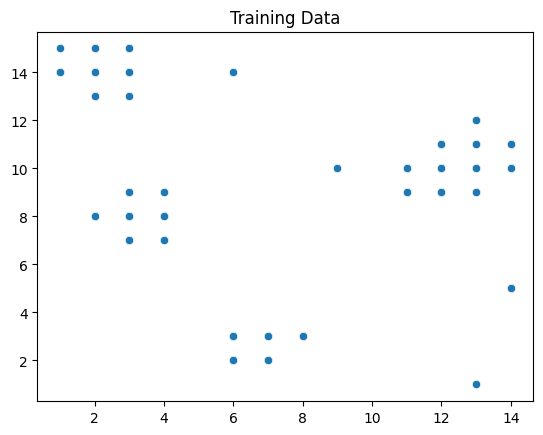

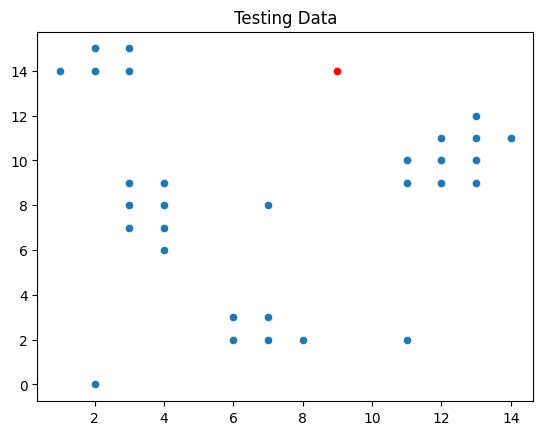

In [22]:




CLUSTER=5

PATH= '../../datasets/good_datasets/l_o8_c5_d2_v0.35_p190_4.npy'
data = import_dataset(PATH)


#data[data[:,2]==11]=[6,14,11]


training_dataset, testing_dataset = split_data(data, CLUSTER)

#training_data=np.load('training.npy')
#testing_data=np.load('testing.npy')

training_data, training_labels = split_dataset_labels(training_dataset)


testing_data,testing_labels=split_dataset_labels(testing_dataset)



sns.histplot(data[:,0])
#sns.kdeplot(testing_data[:,1],label='y')
plt.legend()
plt.figure()
#training_labels
lab=CLUSTER-1

sns.scatterplot(x=data[:,0],y=data[:,1], alpha=0.3)
sns.scatterplot(c='r',x=data[data[:,2]>lab][:,0],y=data[data[:,2]>lab][:,1])


plt.figure()

lab=8
plt.title('Training Data')
sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
sns.scatterplot(c='r',x=training_data[:,0][training_labels==lab],y=training_data[:,1][training_labels==lab])
plt.figure()


plt.title('Testing Data')
sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels==lab],y=testing_data[:,1][testing_labels==lab])

plt.show()







#data = import_dataset(PATH)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the known array for the x-axis values



data=data

x_values = np.arange(0,16,1)
y_values=np.arange(0,16,1)

c_values=[]
for x in x_values:
    row_values=[]
    for y in y_values:
        num=len(data[(data[:,1]==y) & (data[:,0]==x)] )
        
        if num==1:
            if data[(data[:,1]==y) & (data[:,0]==x)][0][2]>=CLUSTER:
            
                row_values.append(-1)
            else:
                row_values.append(1)
        else:
            row_values.append(num)
    c_values.append(row_values)

#c_values=np.array(c_values)/np.max(c_values)


# Ensure the x_values array has the same length as the number of columns


cols = len(x_values)
rows = len(y_values)
# Number of rows in the grid

# Repeat the x_values array to create a 2D array for the grid

values=np.array(c_values)
# Normalize the values to [0, 1] for color mapping

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

# Create a colormap
cmap = plt.get_cmap('bone_r')


# Create the grid



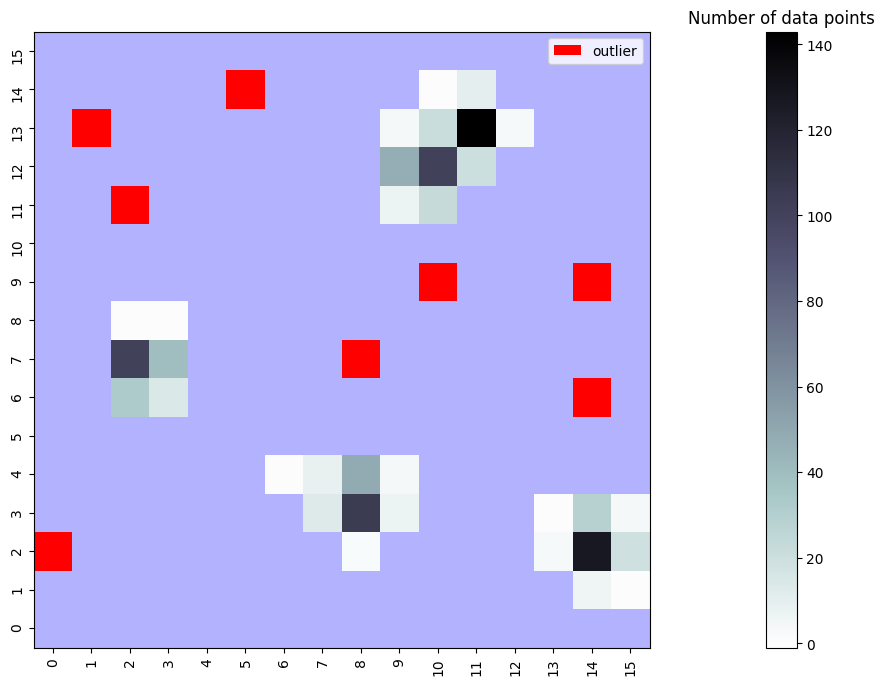

[12 10  2]


In [23]:
fig, ax = plt.subplots(figsize=(30,8))

# Plot each cell with a color corresponding to the value
for i in range(rows):
    for j in range(cols):
        if values[i][j]==0:
            color=(0.0,0.0,1.0,0.3)
        elif values[i][j]==1:
            color=(0.0,0.0,0.0,0.01)
            
        elif values[i][j]==-1:
            color=(1.0,0.0,0.0,1.0)
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color,label='outlier')
        else:
            color = cmap(norm(values[i, j]))
        
        if values[i][j]!=-1:
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color)
        ax.add_patch(rect)

# Set the limits and aspect ratio
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')

# Remove the axes for better visualization


ax.set_xticks(np.arange(0.5,16.5,1))
ax.set_xticklabels(np.arange(0,16,1),rotation=90)
ax.set_yticks(np.arange(0.5,16.5,1))  # Remove y-axis labels
ax.set_yticklabels(np.arange(0,16,1),rotation=90)
# Show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=plt.colorbar(sm, ax=ax)
cbar.ax.set_title('Number of data points')
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))



# Add legend with unique labels
plt.legend(unique_labels.values(), unique_labels.keys())
plt.savefig('../../Downloads/paper_plots/dataset.png')

# Display the plot
plt.show()
print(testing_dataset[3])



In [ ]:
CLUSTER=5

PATH= '../../datasets/good_datasets/l_o8_c5_d2_v0.35_p190_4.npy'
data = import_dataset(PATH)


#data[data[:,2]==11]=[6,14,11]


#np.random.seed(36)
#random.seed(36)

training_dataset, testing_dataset = split_data(data, CLUSTER)

#training_data=np.load('training.npy')
#testing_data=np.load('testing.npy')

training_data, training_labels = split_dataset_labels(training_dataset)


testing_data,testing_labels=split_dataset_labels(testing_dataset)



n_hidden_units=1
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
transverse=True
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted,transverse=transverse)
print('Hamiltonian : ')
print(h)
nparams = len(h)

t_bias=np.random.rand(n_qubits)/n_qubits
t_bias[0:n_visible]=0
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.7782274212954747
learning_rate = 0.6058642443189942
epochs = 7

batch_size=73
dev_name='default.qubit'
#dev_name='lightning.qubit'

weights_batch=[]

fs=[]
rs=[]
ps=[]
f_weights=[]
s=[4,5,6,7]
for i in range(1):

    np.random.seed(s[i])
    random.seed(s[i])
    
    training_dataset, testing_dataset = split_data(data, CLUSTER)


    training_data, training_labels = split_dataset_labels(training_dataset)


    testing_data,testing_labels=split_dataset_labels(testing_dataset)


    θ_init =np.random.rand(nparams)/nparams #np.loadtxt('./weights_7_3_un.txt')


    qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted,transverse=True,t_bias=t_bias)

    errors,weights=qbm.train_model(batch_size,learning_rate)
    p,r,f=evaluate_qbm(qbm,testing_dataset,CLUSTER,plot=True,quantile=0.95,method='mean')
    ps.append(p)
    rs.append(r)
    fs.append(f)
    f_weights.append(weights)

Hamiltonian : 
['XIIIIIIII', 'IXIIIIIII', 'IIXIIIIII', 'IIIXIIIII', 'IIIIXIIII', 'IIIIIXIII', 'IIIIIIXII', 'IIIIIIIXI', 'IIIIIIIIX', 'ZIIIIIIII', 'IZIIIIIII', 'IIZIIIIII', 'IIIZIIIII', 'IIIIZIIII', 'IIIIIZIII', 'IIIIIIZII', 'IIIIIIIZI', 'IIIIIIIIZ', 'ZZIIIIIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIIIZ', 'IZZIIIIII', 'IZIZIIIII', 'IZIIZIIII', 'IZIIIZIII', 'IZIIIIZII', 'IZIIIIIZI', 'IZIIIIIIZ', 'IIZZIIIII', 'IIZIZIIII', 'IIZIIZIII', 'IIZIIIZII', 'IIZIIIIZI', 'IIZIIIIIZ', 'IIIZZIIII', 'IIIZIZIII', 'IIIZIIZII', 'IIIZIIIZI', 'IIIZIIIIZ', 'IIIIZZIII', 'IIIIZIZII', 'IIIIZIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IIIIIZIZI', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIIIZIZ', 'IIIIIIIZZ']

Starting MATLAB engine.. Done.

Epoch 1


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 14%|████████████                                                                        | 1/7 [00:06<00:40,  6.78s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 29%|████████████████████████                                                            | 2/7 [00:12<00:30,  6.14s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 43%|████████████████████████████████████                                                | 3/7 [00:17<00:23,  5.84s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:23<00:17,  5.82s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:29<00:11,  5.72s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:35<00:05,  5.84s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.88s/it]


Epoch 2


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 14%|████████████                                                                        | 1/7 [00:05<00:30,  5.09s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 29%|████████████████████████                                                            | 2/7 [00:11<00:28,  5.62s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 43%|████████████████████████████████████                                                | 3/7 [00:16<00:22,  5.55s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:21<00:16,  5.37s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:26<00:10,  5.19s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:31<00:05,  5.28s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:37<00:00,  5.30s/it]


Epoch 3


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 14%|████████████                                                                        | 1/7 [00:05<00:31,  5.28s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 29%|████████████████████████                                                            | 2/7 [00:10<00:26,  5.25s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 43%|████████████████████████████████████                                                | 3/7 [00:15<00:21,  5.34s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:21<00:15,  5.25s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:25<00:10,  5.07s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:31<00:05,  5.17s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.20s/it]


Epoch 4


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 14%|████████████                                                                        | 1/7 [00:05<00:32,  5.35s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 29%|████████████████████████                                                            | 2/7 [00:10<00:26,  5.27s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 43%|████████████████████████████████████                                                | 3/7 [00:16<00:21,  5.39s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 57%|████████████████████████████████████████████████                                    | 4/7 [00:21<00:15,  5.32s/it]

(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)
(45,)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:26<00:10,  5.12s/it]

In [ ]:
ps

In [ ]:
qbm.H.θ=weights[-1]
p,r,f,da=evaluate_qbm(qbm,testing_dataset,CLUSTER,plot=True,quantile=0.95,method='mean')

In [ ]:
fs=np.load('./QBM_1_seed_avg.npz')['arr_0']
rs=np.load('./QBM_1_seed_avg.npz')['arr_1']
#fs=np.concatenate((fs,np.array([0.214])))
#rs=np.concatenate((rs,np.array([0.75])))
#rbm_f=[0.27272727272727276, 0.25806451612903225, 0.38095238095238093, 0.3, 0.2857142857142857, 0.21428571428571427]
#rbm_f=[0.25806451612903225, 0.38095238095238093, 0.3, 0.2857142857142857, 0.21428571428571427]
rbm_r=[0.75, 1.0, 1.0, 0.75,0.75,1.0]

In [ ]:
import matplotlib.pyplot as plt
import re


def extract_numbers_from_file(filename, keyword):
    with open(filename, 'r') as file:
        content = file.readlines()

    # Pattern to find the keyword followed by ': ' and a floating point number
    pattern = re.compile(rf'{keyword}: (\d+\.\d+)')
    numbers = []

    for line in content:
        match = pattern.search(line)
        if match:
            numbers.append(float(match.group(1)))

    assert len(numbers) == 10
    return numbers


# Create a box plot
def create_boxplot(title, qbm_data, rbm_data, sa_data=None):
    fig, ax = plt.subplots()
    if sa_data:
        data = [qbm_data, sa_data, rbm_data]
        colors = ['pink', 'lightgreen', 'lightblue']
        labels = ['QBM', 'SA', 'RBM']
    else:
        data = [qbm_data, rbm_data]
        colors = ['pink', 'lightblue']
        labels = ['QBM', 'RBM']

    box = ax.boxplot(data,showfliers=True, patch_artist=True, showmeans=True,)

    # Customize box colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Add title and labels
    ax.set_title(title)
    ax.set_ylabel('F1-Score')
    
    ax.set_xticklabels(labels)
    plt.ylim(0.5,1.1)
    plt.legend()
    # Show the plot
    plt.show()
    #plt.savefig(f"plots/{title.replace(' ', '_')}.pdf")


def create_boxplot_from_files(fs, metric, title):
    # Extract data from files
    qbm_data = rs
    rbm_data = rbm_r
   
    create_boxplot(title, qbm_data, rbm_data)


filenames = ['d_wave_runs.txt', 'rbm.txt']

# plot F1 Score
metric = 'F1-Score'
title = 'F1-Scores Distribution'
create_boxplot_from_files(fs,'f1',title)

# plot recall
#metric = 'Recall'
#title = 'Recalls of the different models'
#create_boxplot_from_files(filenames, metric, title)



In [ ]:
np.average(rbm_f
          )

In [ ]:
rs

In [ ]:
np.average([0.14814814814814814, 0.23529411764705882, 0.1875, 0.17647058823529413, 0.125])